<a href="https://colab.research.google.com/github/NohemiVargas/Procesamiento_y_clasificacion_datos/blob/main/ProyectoFinal/C%C3%B3digo_Maternal_risk_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Identificación de niveles de riesgo en el embarazo mediante Machine Learning.
#Laura Nohemí Vargas de la Rosa



## Declaración de librerías

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import matplotlib.ticker as ticker

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVC

## Carga de datos


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/Colaboratory/Procesamiento y clasificación de Datos/Tarea 1/Maternal Health Risk Data Set.csv')

In [4]:
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [5]:
data.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel'],
      dtype='object')

In [6]:
data['RiskLevel'].replace({"high risk": "3", "mid risk": "2", "low risk" : "1"}, inplace=True)
data['RiskLevel'] = data['RiskLevel'].astype(float)
data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,3.0
1,35,140,90,13.0,98.0,70,3.0
2,29,90,70,8.0,100.0,80,3.0
3,30,140,85,7.0,98.0,70,3.0
4,35,120,60,6.1,98.0,76,1.0


In [7]:
data2 = data.drop('RiskLevel', axis=1)
data2.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,25,130,80,15.0,98.0,86
1,35,140,90,13.0,98.0,70
2,29,90,70,8.0,100.0,80
3,30,140,85,7.0,98.0,70
4,35,120,60,6.1,98.0,76


## Estadística descriptiva para variables numéricas

In [8]:
data.select_dtypes(include=['float64', 'int']).describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775,1.867850
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702,0.807353
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000,1.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000,1.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000,2.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000,3.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000,3.000000


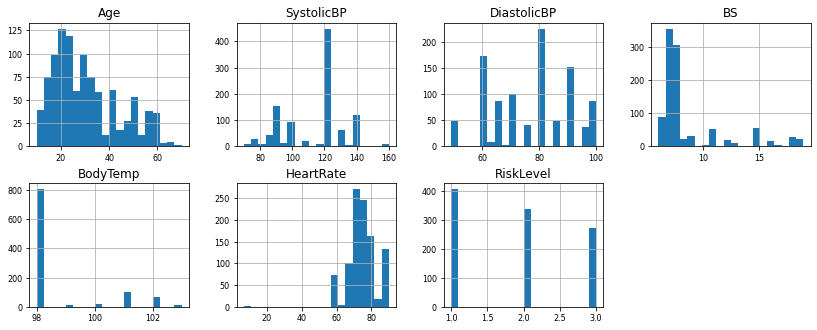

In [9]:
numerical=data.select_dtypes(include=[np.number]).columns.tolist()
data[numerical].hist(bins=20, figsize=(14, 20), layout=(7, 4), xlabelsize=8, ylabelsize=8);

Correlación

In [10]:
def tidy_corr_matrix(corr_mat):
    '''
    Function to convert a pandas correlation matrix in tidy format
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

data2 = data.drop('RiskLevel', axis=1)

corr_matrix =  data2.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
13,DiastolicBP,SystolicBP,0.787006,0.787006
8,SystolicBP,DiastolicBP,0.787006,0.787006
18,BS,Age,0.473284,0.473284
3,Age,BS,0.473284,0.473284
19,BS,SystolicBP,0.425172,0.425172
9,SystolicBP,BS,0.425172,0.425172
20,BS,DiastolicBP,0.423824,0.423824
15,DiastolicBP,BS,0.423824,0.423824
1,Age,SystolicBP,0.416045,0.416045
6,SystolicBP,Age,0.416045,0.416045


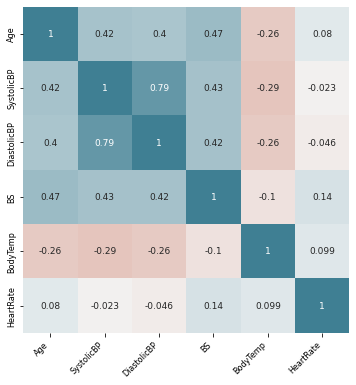

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 9},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)


Distribución por nivel de riesgo

In [12]:
pd.value_counts(data['RiskLevel'])

1.0    406
2.0    336
3.0    272
Name: RiskLevel, dtype: int64

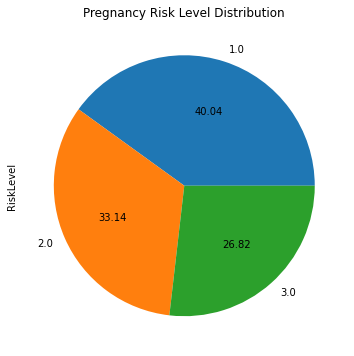

In [13]:
plot = data['RiskLevel'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6),
                                            title='Pregnancy Risk Level Distribution')

IndexError: ignored

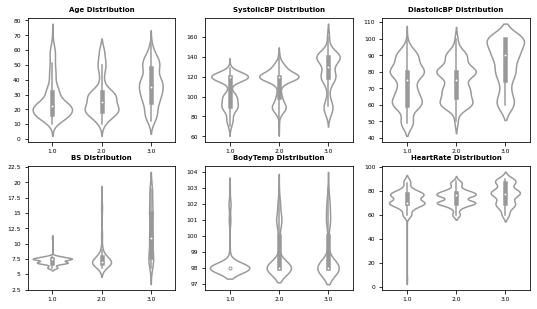

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = data.select_dtypes(include=['float64', 'int']).columns
for i, colum in enumerate(columnas_numeric):
    sns.violinplot(
        x     = 'RiskLevel',
        y     = colum,
        data  = data,
        color = "white",
        ax    = axes[i]
    )
    axes[i].set_title(f"{colum} Distribution", fontsize = 7, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribution of the variables per Risk Level', fontsize = 10, fontweight = "bold");

## Estandarización

In [17]:
sc=StandardScaler()
#sc=MinMaxScaler()
data_standard=sc.fit_transform(data2)
data_standard=pd.DataFrame(data_standard)
data_standard.columns=['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
data_standard.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,-0.361738,0.913396,0.255023,1.905890,-0.485215,1.446956
1,0.380777,1.457027,0.975539,1.298340,-0.485215,-0.532088
2,-0.064732,-1.261127,-0.465493,-0.220537,0.973884,0.704815
3,0.009519,1.457027,0.615281,-0.524312,-0.485215,-0.532088
4,0.380777,0.369765,-1.186009,-0.797710,-0.485215,0.210054


In [18]:
data_standard['RiskLevel']=data['RiskLevel']
data_standard.head(4)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,-0.361738,0.913396,0.255023,1.905890,-0.485215,1.446956,3.0
1,0.380777,1.457027,0.975539,1.298340,-0.485215,-0.532088,3.0
2,-0.064732,-1.261127,-0.465493,-0.220537,0.973884,0.704815,3.0
3,0.009519,1.457027,0.615281,-0.524312,-0.485215,-0.532088,3.0


In [19]:
#split dataset in features and target variable
feature_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
X = data_standard[feature_cols] # Features
y = data_standard.RiskLevel # Target variable

In [20]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

## K-nearest neighbor

In [21]:
#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,y)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.8363312685948397
Best Parameters: {'n_neighbors': 1}


In [22]:
#model 
knn2=KNeighborsClassifier(n_neighbors=1)

In [23]:
# fit the model with data
knn2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [24]:
y_pred = knn2.predict(X_test)

In [25]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[77, 21,  5],
       [ 7, 74,  8],
       [ 2,  1, 59]])

In [26]:
y_pred2=pd.DataFrame(y_pred)
y_test2=pd.DataFrame(y_test)
y_test3=y_test2.reset_index()
df = y_test3.assign(y_pred2= y_pred2)
df

,index,RiskLevel,y_pred2
0,494,1.0,1.0
1,271,1.0,1.0
2,963,3.0,3.0
3,558,1.0,1.0
4,614,3.0,3.0
...,...,...,...
249,909,1.0,1.0
250,644,3.0,3.0
251,164,1.0,1.0
252,795,2.0,1.0


Text(0.5, 257.44, 'Predicted label')

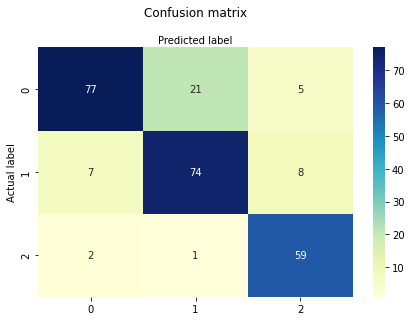

In [27]:
# create heatmap
class_names=[1,2,3] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [28]:
target_names = ['Low Risk', 'Medium Risk', 'High Risk']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Low Risk       0.90      0.75      0.81       103
 Medium Risk       0.77      0.83      0.80        89
   High Risk       0.82      0.95      0.88        62

    accuracy                           0.83       254
   macro avg       0.83      0.84      0.83       254
weighted avg       0.83      0.83      0.83       254



## Arbol de decision

In [29]:
#GRIDSEARCH
#create a dictionary of all values we want to test
param_grid = {'criterion':['gini', 'entropy'],'max_depth': list(range(3,15))}
# decision tree model
dtree_model=DecisionTreeClassifier(random_state=1)
#use gridsearch to test all values
dtree_gscv = GridSearchCV(dtree_model, param_grid)# cv default = 5 = 5-fold cv
 #fit model to data
dtree_gscv.fit(X_train, y_train)
print("Tuned hyperparameters Criterion: {}, Max_depth: {}".format
      (dtree_gscv.best_params_['criterion'],dtree_gscv.best_params_['max_depth'])) 
print("Best score: {}".format(dtree_gscv.best_score_))

Tuned hyperparameters Criterion: gini, Max_depth: 14
Best score: 0.7947368421052632


In [30]:
#model 
dt=DecisionTreeClassifier(criterion = 'gini', max_depth=14, random_state=1)

In [31]:
# fit the model with data
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=14, random_state=1)

In [32]:
y_pred = dt.predict(X_test)

In [33]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[84, 15,  4],
       [13, 69,  7],
       [ 1,  4, 57]])

Text(0.5, 15.0, 'Predicted label')

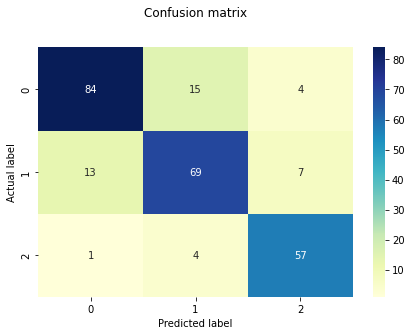

In [34]:
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [35]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Low Risk       0.86      0.82      0.84       103
 Medium Risk       0.78      0.78      0.78        89
   High Risk       0.84      0.92      0.88        62

    accuracy                           0.83       254
   macro avg       0.83      0.84      0.83       254
weighted avg       0.83      0.83      0.83       254



## Random forest

In [ ]:
#GRIDSEARCH
param_grid = { 
    'n_estimators': [10,50,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'criterion' :['gini', 'entropy']
}
rfc =RandomForestClassifier(random_state=1)
rfc_gscv=GridSearchCV(estimator=rfc, param_grid=param_grid) # cv default = 5
rfc_gscv.fit(X_train,y_train)

print("Tuned best parameters for random forest: ",rfc_gscv.best_params_ ) 
print("Best score: {}".format(rfc_gscv.best_score_))


In [37]:
#model 
RF=RandomForestClassifier(criterion = 'entropy', max_depth=20, max_features= 'auto', n_estimators= 100, random_state=1)

In [38]:
# fit the model with data
RF.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(criterion='entropy', max_depth=20, max_features='auto',
                       random_state=1)

In [39]:
y_pred = RF.predict(X_test)

In [40]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[78, 22,  3],
       [ 7, 75,  7],
       [ 1,  4, 57]])

Text(0.5, 15.0, 'Predicted label')

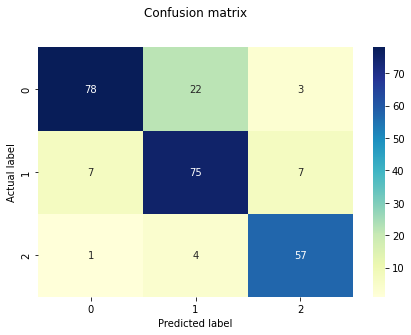

In [41]:
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [42]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Low Risk       0.91      0.76      0.83       103
 Medium Risk       0.74      0.84      0.79        89
   High Risk       0.85      0.92      0.88        62

    accuracy                           0.83       254
   macro avg       0.83      0.84      0.83       254
weighted avg       0.84      0.83      0.83       254



## Maquina de soporte vectorial

In [43]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000],'decision_function_shape':['ovo']},
                {'kernel': ['linear'], 'C': [1, 10, 100, 1000],'decision_function_shape':['ovo']},
                {'kernel': ['poly'], 'degree':[3],'C': [1, 10, 100, 1000],'decision_function_shape':['ovo']},
                {'kernel': ['sigmoid'],'C': [1, 10, 100, 1000],'decision_function_shape':['ovo']}]

In [44]:
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'decision_function_shape': ['ovo'],
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000],
                          'decision_function_shape': ['ovo'],
                          'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'decision_function_shape': ['ovo'], 'degree': [3],
                          'kernel': ['poly']},
                         {'C': [1, 10, 100, 1000],
                          'decision_function_shape': ['ovo'],
                          'kernel': ['sigmoid']}])

In [45]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
y_pred = final_model.predict(X_test)

Best score for training data: 0.7236842105263157 

Best C: 1000 

Best Kernel: poly 

Best Gamma: scale 



In [46]:
# Making the Confusion Matrix
#print(pd.crosstab(Y_test_label, Y_pred_label, rownames=['Actual Activity'], colnames=['Predicted Activity']))
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for SVM: %f" % final_model.score(X_train, y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test, y_test ))

svm_model.score

[[78 22  3]
 [39 43  7]
 [ 8  9 45]]


              precision    recall  f1-score   support

         1.0       0.62      0.76      0.68       103
         2.0       0.58      0.48      0.53        89
         3.0       0.82      0.73      0.77        62

    accuracy                           0.65       254
   macro avg       0.67      0.66      0.66       254
weighted avg       0.66      0.65      0.65       254

Training set score for SVM: 0.789474
Testing  set score for SVM: 0.653543


<bound method BaseSearchCV.score of GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'decision_function_shape': ['ovo'],
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000],
                          'decision_function_shape': ['ovo'],
                          'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'decision_function_shape': ['ovo'], 'degree': [3],
                          'kernel': ['poly']},
                         {'C': [1, 10, 100, 1000],
                          'decision_function_shape': ['ovo'],
                          'kernel': ['sigmoid']}])>

In [47]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[78, 22,  3],
       [39, 43,  7],
       [ 8,  9, 45]])

Text(0.5, 15.0, 'Predicted label')

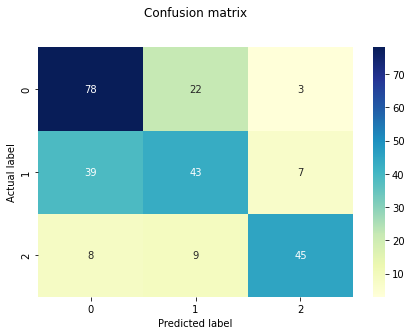

In [48]:
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')